# algebra dataset preprocessing
### Import

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import json
import pandas as pd
import numpy as np
from liriscat.dataset.preprocessing_utilities import *
from liriscat.utils import utils
import torch
utils.set_seed(0)

CUDA is not available. Skipping CUDA seed setting.


In [27]:
import os

# Example: change to a directory called "experiments"
os.chdir("/lustre/fsn1/projects/rech/enh/unv34ei/liriscat/experiments/datasets/3-dataset_preprocessing_notebooks")

# Verify
print("Now in:", os.getcwd())


Now in: /lustre/fsn1/projects/rech/enh/unv34ei/liriscat/experiments/datasets/3-dataset_preprocessing_notebooks


### Load and merge dataset

In [28]:
raw_data = pd.read_csv('../1-raw_data/algebra.csv', encoding="ISO-8859-15", low_memory=False)

raw_data = raw_data.drop(columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.2','Unnamed: 0.1.1','Unnamed: 0.1.1.1','Row','PH','PN','PV','SN','Step Start Time','start_time','Correct Transaction Time','Step End Time','Step Duration (sec)','Correct Step Duration (sec)','Error Step Duration (sec)','Incorrects','Hints','Corrects','KC(Default)','Opportunity(Default)','KC2','qr','qr_compl'])

raw_data =  raw_data.rename(columns={"skill_id": "dimension_id"})
raw_data.head()

,dimension_id,user_id,item_id,correct
0,{106},0,0,0
1,{106},0,1,0
2,{61},0,2,0
3,"{25, 133}",0,3,0
4,{99},0,4,0


### Split rows with several dimensions

In [29]:
raw_data['dimension_id'] = raw_data['dimension_id'].apply(lambda x: set(map(int, x.strip('{}').split(', '))))
df_expanded = raw_data.explode('dimension_id').reset_index(drop=True)
df_expanded.head()

,dimension_id,user_id,item_id,correct
0,106,0,0,0
1,106,0,1,0
2,61,0,2,0
3,25,0,3,0
4,133,0,3,0


### Binarize all responses for homogeneity purpose

In [30]:
df_expanded['correct']=df_expanded['correct'].round()
print(len(df_expanded))

616730


### Early stats

In [31]:
print(len(df_expanded))
all_data = df_expanded.dropna(subset=['user_id','item_id','correct','dimension_id'])
print(len(all_data))

616730
616730


In [32]:
stat_unique(all_data, None)
stat_unique(all_data, ['user_id', 'item_id'])
stat_unique(all_data, 'user_id')
stat_unique(all_data, 'item_id')
stat_unique(all_data, 'dimension_id')

Total length: 616730
Number of unique [user_id,item_id]: 447628
Number of unique user_id: 830
Number of unique item_id: 2365
Number of unique dimension_id: 136


### Clean Nan values

In [33]:
cleaned_data = all_data.dropna(subset=['user_id','item_id','correct','dimension_id'], axis='index')

### Remove duplicated user and id rows

In [34]:
unduplicated_data = remove_duplicates(cleaned_data,key_attrs=['user_id','item_id','dimension_id'],agg_attrs=[])

### Filter Data

In [35]:
filtered_data_0 = unduplicated_data
filtered_q_nb = 1
filtered_u_nb = 0
filtered_d_nb = 0
while filtered_q_nb!=0 or filtered_u_nb!=0 or filtered_d_nb!=0 : 
    # filter items
    filtered_data_1, filtered_q_nb = densify(filtered_data_0,'item_id','user_id',3)
    # filter users
    min_nb_users_logs = 16
    filtered_data_2, filtered_u_nb = densify(filtered_data_1,'user_id','item_id',min_nb_users_logs)
    # filter knowledges
    filtered_data_3, filtered_d_nb = densify(filtered_data_2,'dimension_id','item_id',1)
    filtered_data_0 = filtered_data_3
    
stat_unique(filtered_data_0, None)
stat_unique(filtered_data_0, ['user_id', 'item_id'])
stat_unique(filtered_data_0, 'user_id')
stat_unique(filtered_data_0, 'item_id')
stat_unique(filtered_data_0, 'dimension_id')

filter 0 item_id
filter 0 user_id
filter 0 dimension_id
Total length: 616730
Number of unique [user_id,item_id]: 447628
Number of unique user_id: 830
Number of unique item_id: 2365
Number of unique dimension_id: 136


### Encoding

In [36]:
# renumber the users
u_enc_data, u2n = encode_attr(filtered_data_0, "user_id")

In [37]:
# renumber the items
q_enc_data, q2n = encode_attr(u_enc_data, "item_id")

In [38]:
# renumber the dimensions
d_enc_data, d2n = encode_attr(q_enc_data, "dimension_id")

### Maps creation

In [39]:
q2k, k2q = create_q2k(d_enc_data)

### Rescaling responses

In [40]:
resc_data = d_enc_data
resc_data['correct'] = resc_data['correct'].astype(float)
min_val = resc_data['correct'].min()
max_val = resc_data['correct'].max()
resc_data['correct'] = (resc_data['correct']-min_val)/(max_val-min_val) +1
print(f'min value : {resc_data["correct"].min()}, max value : {resc_data["correct"].max()}')

min value : 1.0, max value : 2.0


### Get final stats and create metadata

In [50]:
stat_unique(resc_data, None)
stat_unique(resc_data, ['user_id', 'item_id'])
stat_unique(resc_data, 'user_id')
stat_unique(resc_data, 'item_id')
stat_unique(resc_data, 'dimension_id')
stat_unique(resc_data, 'correct')

resc_data_dim_grouped_items = resc_data.groupby("dimension_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("dimension_id")["user_id"].nunique()
print('#questions/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("item_id")["dimension_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("item_id")["user_id"].nunique()
print('#categorys/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("user_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("user_id")["dimension_id"].nunique()
max_nb_q_per_users = np.max(resc_data_dim_grouped_items)
min_nb_users_logs = np.min(resc_data_dim_grouped_items)
print('#questions/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#categorys/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

Total length: 616730
Number of unique [user_id,item_id]: 447628
Number of unique user_id: 830
Number of unique item_id: 2365
Number of unique dimension_id: 136
Number of unique correct: 2
#questions/category: 1 & 24 &  704
#users/category: 3 & 385 &  830
#categorys/question: 1 & 1 &  28
#users/question: 100 & 189 &  545
#questions/users: 100 & 539 &  1430
#categorys/users: 7 & 63 &  127


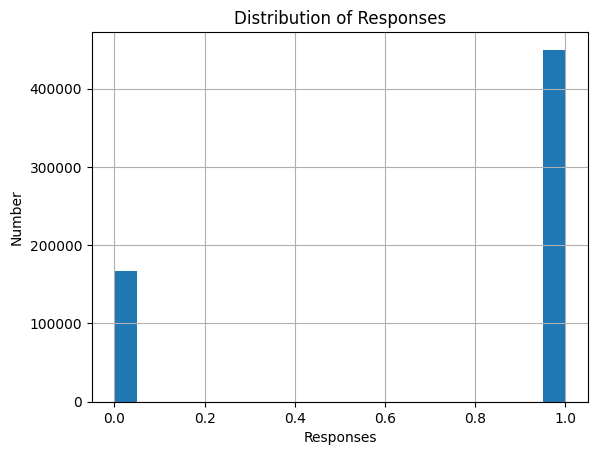

In [52]:
import matplotlib.pyplot as plt

# draw a histogram of the age column
(resc_data['correct']-1).hist(bins=20)

# add labels and title
plt.xlabel('Responses')
plt.ylabel('Number')
plt.title('Distribution of Responses')
plt.savefig('../4-figs/distribution_algebra.png')


In [53]:
resc_data_dim_grouped_items = resc_data.groupby("item_id")["dimension_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("item_id")["user_id"].nunique()
metadata = get_metadata(resc_data,["user_id", "item_id", "dimension_id"])
metadata['min_nb_users_logs'] = int(min_nb_users_logs)
metadata['max_nb_categories_per_question'] = int(np.max(resc_data_dim_grouped_items))
metadata['max_nb_questions_per_user'] = int(max_nb_q_per_users)

### Compute nb of modalities per item

In [54]:
nb_modalities = get_modalities_nb(resc_data, metadata)

### Save data, concept map, metadata and nb_modalities

In [55]:
new_order = ['user_id','item_id', 'correct', 'dimension_id']
resc_data = resc_data[new_order]

In [56]:
# save selected data
resc_data.to_csv('../1-raw_data/algebra_selected_data.csv', index=False)

In [57]:
# Convert int64 keys to str
q2k_str_keys = {str(key): value for key, value in q2k.items()}

# Convert sets to lists in the dictionary
q2k_json_serializable = {}
for key, value in q2k_str_keys.items():
    if isinstance(value, set):
        q2k_json_serializable[key] = list(value)
    else:
        q2k_json_serializable[key] = value

# Save concept map
with open('../2-preprocessed_data/algebra_concept_map.json', 'w') as f:
    json.dump(q2k_json_serializable, f)

In [58]:
# save metadata
with open('../2-preprocessed_data/algebra_metadata.json', 'w') as f:
    json.dump(metadata, f)

In [25]:
# save metadata
torch.save(nb_modalities,'../2-preprocessed_data/algebra_nb_modalities.pkl')

## parse data

In [26]:
from liriscat import utils
utils.setuplogger(verbose = True,log_path = "../../logs/", log_name="liriscat")
utils.set_seed(0)

In [27]:
import pandas as pd
from liriscat.dataset.preprocessing_utilities import *
resc_data = pd.read_csv('../1-raw_data/algebra_selected_data.csv')

In [28]:
train, valid, test = split_users(resc_data, 5)

## save data

In [29]:
for i_fold, train_fold in enumerate(train):
    save_df_to_csv(train[i_fold], f'../2-preprocessed_data/algebra_train_{i_fold}.csv')
    save_df_to_csv(valid[i_fold], f'../2-preprocessed_data/algebra_valid_{i_fold}.csv')
    save_df_to_csv(test[i_fold], f'../2-preprocessed_data/algebra_test_{i_fold}.csv')

    train_valid_df = pd.concat([train[i_fold], valid[i_fold]])
    # Split the merged data horizontally into train and validation sets.

    quadruplet = quadruplet_format(train_valid_df)
    vertical_train, vertical_valid = split_data_vertically_unique_fold(quadruplet, valid_prop=0.1)

    save_df_to_csv(vertical_train, f'../2-preprocessed_data/algebra_vert_train_{i_fold}.csv')
    save_df_to_csv(vertical_valid, f'../2-preprocessed_data/algebra_vert_valid_{i_fold}.csv')

